## Overview
## Titanic: Machine Learning from Disaster
The data has been split into two groups:

training set (train.csv)

test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary

Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes;
pclass	    Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd;
sex	        Sex;
Age	        Age in years;	
sibsp	    # of siblings / spouses aboard the Titanic;	
parch	    # of parents / children aboard the Titanic;	
ticket	    Ticket number;	
fare	    Passenger fare;	
cabin	    Cabin number;	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [289]:
# importing the required packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

import sys
import re
import os
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

import sklearn
import xgboost as xgb

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Let's use the following base models
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

### Data Exploration and Feature Engineering

In [290]:
# Load the train and test datasets

train = pd.read_csv('Downloads/titanic/train.csv')
test = pd.read_csv('Downloads/titanic/test.csv')
final_test_result_survived = pd.read_csv('Downloads/titanic/gender_submission.csv')

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [291]:
train.columns, test.columns

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'))

In [292]:
train.shape, test.shape

((891, 12), (418, 11))

In [293]:
# add the field 'Survived' to test dataset
test = pd.merge(test, final_test_result_survived, how = "inner", on = 'PassengerId')

In [294]:
test.shape

(418, 12)

In [295]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [296]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.363636
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,0.481622
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,1.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000


In [297]:
# here the following columns cannot be used directly in predicting the Survival of a person as it won't be helpful -
# - so it has to be transformed:
# Name, PassengerId, Ticket, Cabin

# lets look at the null values and unique values in each of the variable
unique_count = []
for i in train.columns:
    unique_count.append((i, train[i].nunique()))

sorted(unique_count, key=lambda x:(-x[1],x[0]))


[('Name', 891),
 ('PassengerId', 891),
 ('Ticket', 681),
 ('Fare', 248),
 ('Cabin', 147),
 ('Age', 88),
 ('Parch', 7),
 ('SibSp', 7),
 ('Embarked', 3),
 ('Pclass', 3),
 ('Sex', 2),
 ('Survived', 2)]

In [298]:
train['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [299]:
# from the column 'Name' we can try to extract the titles so that 
print(re.search('([A-Za-z]+)\.', 'Braund, Mr. Owen Harris'))
print(re.search('([A-Za-z]+)\.', 'Nasser, Mrs. Nicholas (Adele Achem)'))
print(re.search('([A-Za-z]+)\.', 'Heikkinen, Miss. Laina'))
print(re.search('([A-Za-z]+)\.', 'McCarthy, Mr. Timothy J'))


<_sre.SRE_Match object; span=(8, 11), match='Mr.'>
<_sre.SRE_Match object; span=(8, 12), match='Mrs.'>
<_sre.SRE_Match object; span=(11, 16), match='Miss.'>
<_sre.SRE_Match object; span=(10, 13), match='Mr.'>


In [300]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [301]:
# lets look at the null values in each variable

train.isna().sum()
# from the following data we can see that the column "Age" has 177 missing values 
# and column "Cabin" has 687 missing values out of 891 passengers

# % of missing values
pct_missing = []
for i in train.columns:
    pct_missing.append((i, round(100.00*train[i].isna().sum()/train.shape[0], 2)))

sorted(pct_missing, key = lambda x:(-x[1],x[0]))

[('Cabin', 77.1),
 ('Age', 19.87),
 ('Embarked', 0.22),
 ('Fare', 0.0),
 ('Name', 0.0),
 ('Parch', 0.0),
 ('PassengerId', 0.0),
 ('Pclass', 0.0),
 ('Sex', 0.0),
 ('SibSp', 0.0),
 ('Survived', 0.0),
 ('Ticket', 0.0)]

In [302]:
# Since the field 'Embarked' is discrete, lets measure the frequency of each value in it
train['Embarked'].value_counts()
# the value 'S' is repeating most of the times hence we can try to fill the missing values with 'S'

S    644
C    168
Q     77
Name: Embarked, dtype: int64

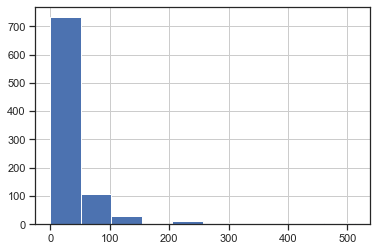

In [303]:
train['Fare'].hist()

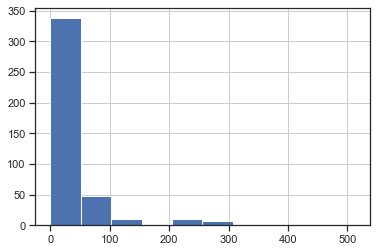

In [304]:
test['Fare'].hist()

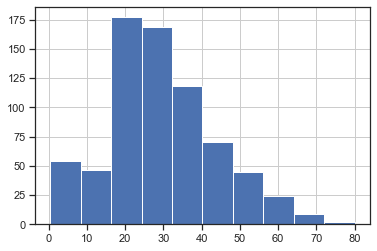

In [305]:
train['Age'].hist()

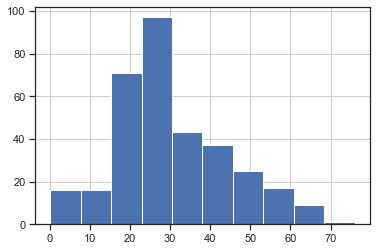

In [306]:
test['Age'].hist()

In [307]:
# lets try to do some feature engineering based on the above analysis

# for column 'Name' lets try to add the length of it
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# since we have 79% missing values for the field 'Cabin', lets try to add a feature whether the customer has cabin or not
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# creating a list to store both train and test datasets in a list
full_data = [train, test]

# lets create a new feature called 'FamilySize' from the combination of fields 'SibSp' and 'Parch'
for data in full_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
# create a new feature IsAlone from FamilySize
for data in full_data:
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
    
# As the column 'Embarked' has 22% null values and the most frequency value is 'S'. Lets try to fill it.
for data in full_data:
    data['Embarked'] = data['Embarked'].fillna('S')
    
# since the "Fare" is ranging from $0 to $500. Lets create a discrete variable based on the 4 quantiles
for data in full_data:
    data['CategoricalFare'] = pd.qcut(data['Fare'], 4, duplicates='drop')
    
# the column 'Age' has around 20% null values. Lets try to fill them using the normal distribution mean and standard - 
# - deviation method
for data in full_data:
    age_avg = data['Age'].mean()
    age_std = data['Age'].std()
    age_null_count = data['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    data['Age'][np.isnan(data['Age'])] = age_null_random_list
    data['Age'] = data['Age'].astype(int)
    
    # lets create a categorical age feature as well in 5 buckets
    data['CategoricalAge'] = pd.cut(data['Age'], 5)
    
# from the passenger names we can extract their titles and this might be helpful for us
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for data in full_data:
    data['Title'] = data['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for data in full_data:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
                                           'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

# mapping the columns : 'Sex', 'Title', 'Embarked', 'Fare', and 'Age'
# the mapped columns 'Sex', 'Title', 'Embarked' are still discrete variables
# the mapped columns 'Fare' and 'Age' are going to be Ordinal

for data in full_data:
    # Mapping Sex
    data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} )
    #data['Sex'] = data['Sex'].astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)
    
    # Mapping Embarked
    data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
    #print(list(data['Embarked']))
    
    # Mapping Fare
    data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare'] = 3
    #print(list(data['Fare']))
    data['Fare'] = data['Fare']
    
    # Mapping Age
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4 


In [308]:
train.columns

# we have successfully added all the potential columns from the above analysis. The new columns are as follows:
# 'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'CategoricalFare', 'CategoricalAge', 'Title'

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Name_length',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'CategoricalFare',
       'CategoricalAge', 'Title'],
      dtype='object')

In [309]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0.0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3.0,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1.0,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3.0,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1.0,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


In [310]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,1.341190,0.523008,0.381594,1.505051,0.361392,26.965208,0.228956,1.904602,0.602694,1.728395
std,257.353842,0.486592,0.836071,0.477990,0.845529,1.102743,0.806057,1.118148,0.635673,9.281607,0.420397,1.613459,0.489615,1.030039
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.500000,0.000000,20.000000,0.000000,1.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,25.000000,0.000000,1.000000,1.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,30.000000,0.000000,2.000000,1.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,4.000000,8.000000,6.000000,3.000000,2.000000,82.000000,1.000000,11.000000,1.000000,5.000000


In [311]:
for i in train.columns:
    print((i, train[i].nunique()))

('PassengerId', 891)
('Survived', 2)
('Pclass', 3)
('Name', 891)
('Sex', 2)
('Age', 5)
('SibSp', 7)
('Parch', 7)
('Ticket', 681)
('Fare', 4)
('Cabin', 147)
('Embarked', 3)
('Name_length', 50)
('Has_Cabin', 2)
('FamilySize', 9)
('IsAlone', 2)
('CategoricalFare', 4)
('CategoricalAge', 5)
('Title', 5)


In [312]:
# Now we can remove the unwanted features from the data as they are not useful for building the model
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']

train = train.drop(drop_cols, axis = 1)
test = test.drop(drop_cols, axis = 1)

# lets also drop the columns - 'CategoricalAge', 'CategoricalFare' as we have created them separately as 'Fare' and 'Age'
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)


In [313]:
train.columns

# Now that we have finalized on the columns lets look at some data visualisations for better understanding

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')

### Data Visualization

In [314]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,1
1,1,1,0,2,0,3.0,1,51,1,2,0,3
2,1,3,0,1,0,1.0,0,22,0,1,1,2
3,1,1,0,2,0,3.0,0,44,1,2,0,3
4,0,3,1,2,0,1.0,0,24,0,1,1,1


In [315]:
train['Fare'] = train['Fare'].astype(int)

In [316]:
train.head()

for i in train.columns:
    print((i, train[i].nunique()))

# lets classify the following features into continuous, discrete, binary, and ordinal. It is important for modeling
# continuous: 'Age', 'Name_length'
# discrete: 'Embarked', 'Title'
# binary: 'Survived', 'Sex', 'Has_Cabin', 'IsAlone'
# ordinal: 'Age', 'Pclass', 'Age', 'Parch', 'Fare', 'Name_length', 'FamilySize'

('Survived', 2)
('Pclass', 3)
('Sex', 2)
('Age', 5)
('Parch', 7)
('Fare', 4)
('Embarked', 3)
('Name_length', 50)
('Has_Cabin', 2)
('FamilySize', 9)
('IsAlone', 2)
('Title', 5)


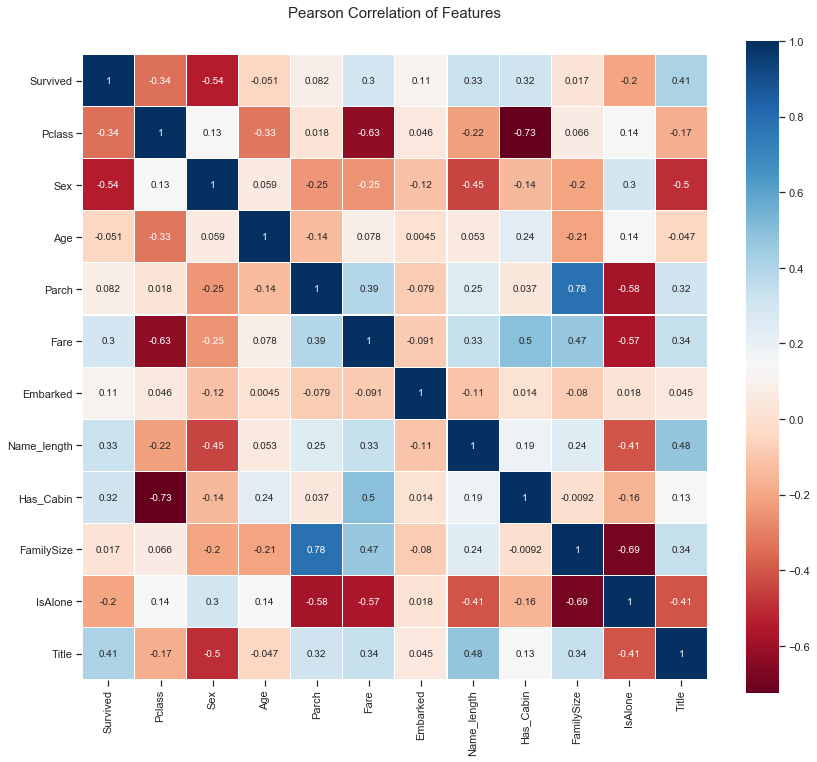

In [317]:
# lets look at the correlation between each of the variables
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#### From the above correlations we can see that not too many features strongly correlated with one another. This is good because we don't have redundancy in the data and each feature carries some information. Here are two most correlated features are that of Family size and Parch (Parents and Children).

In [318]:
# correlation of the variables wrt target variable
train_corr = train.corr()['Survived']

golden_features_list = train_corr[abs(train_corr) > 0.3].sort_values(ascending=False)

print("There are {} strongly correlated values with OD_amt_usd:\n{}".\
      format(len(golden_features_list), golden_features_list))

# the following variables have strong correlation with predictive variable
# Title, Name_length, Has_Cabin, Pclass, Sex

There are 6 strongly correlated values with OD_amt_usd:
Survived       1.000000
Title          0.407753
Name_length    0.332350
Has_Cabin      0.316912
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64


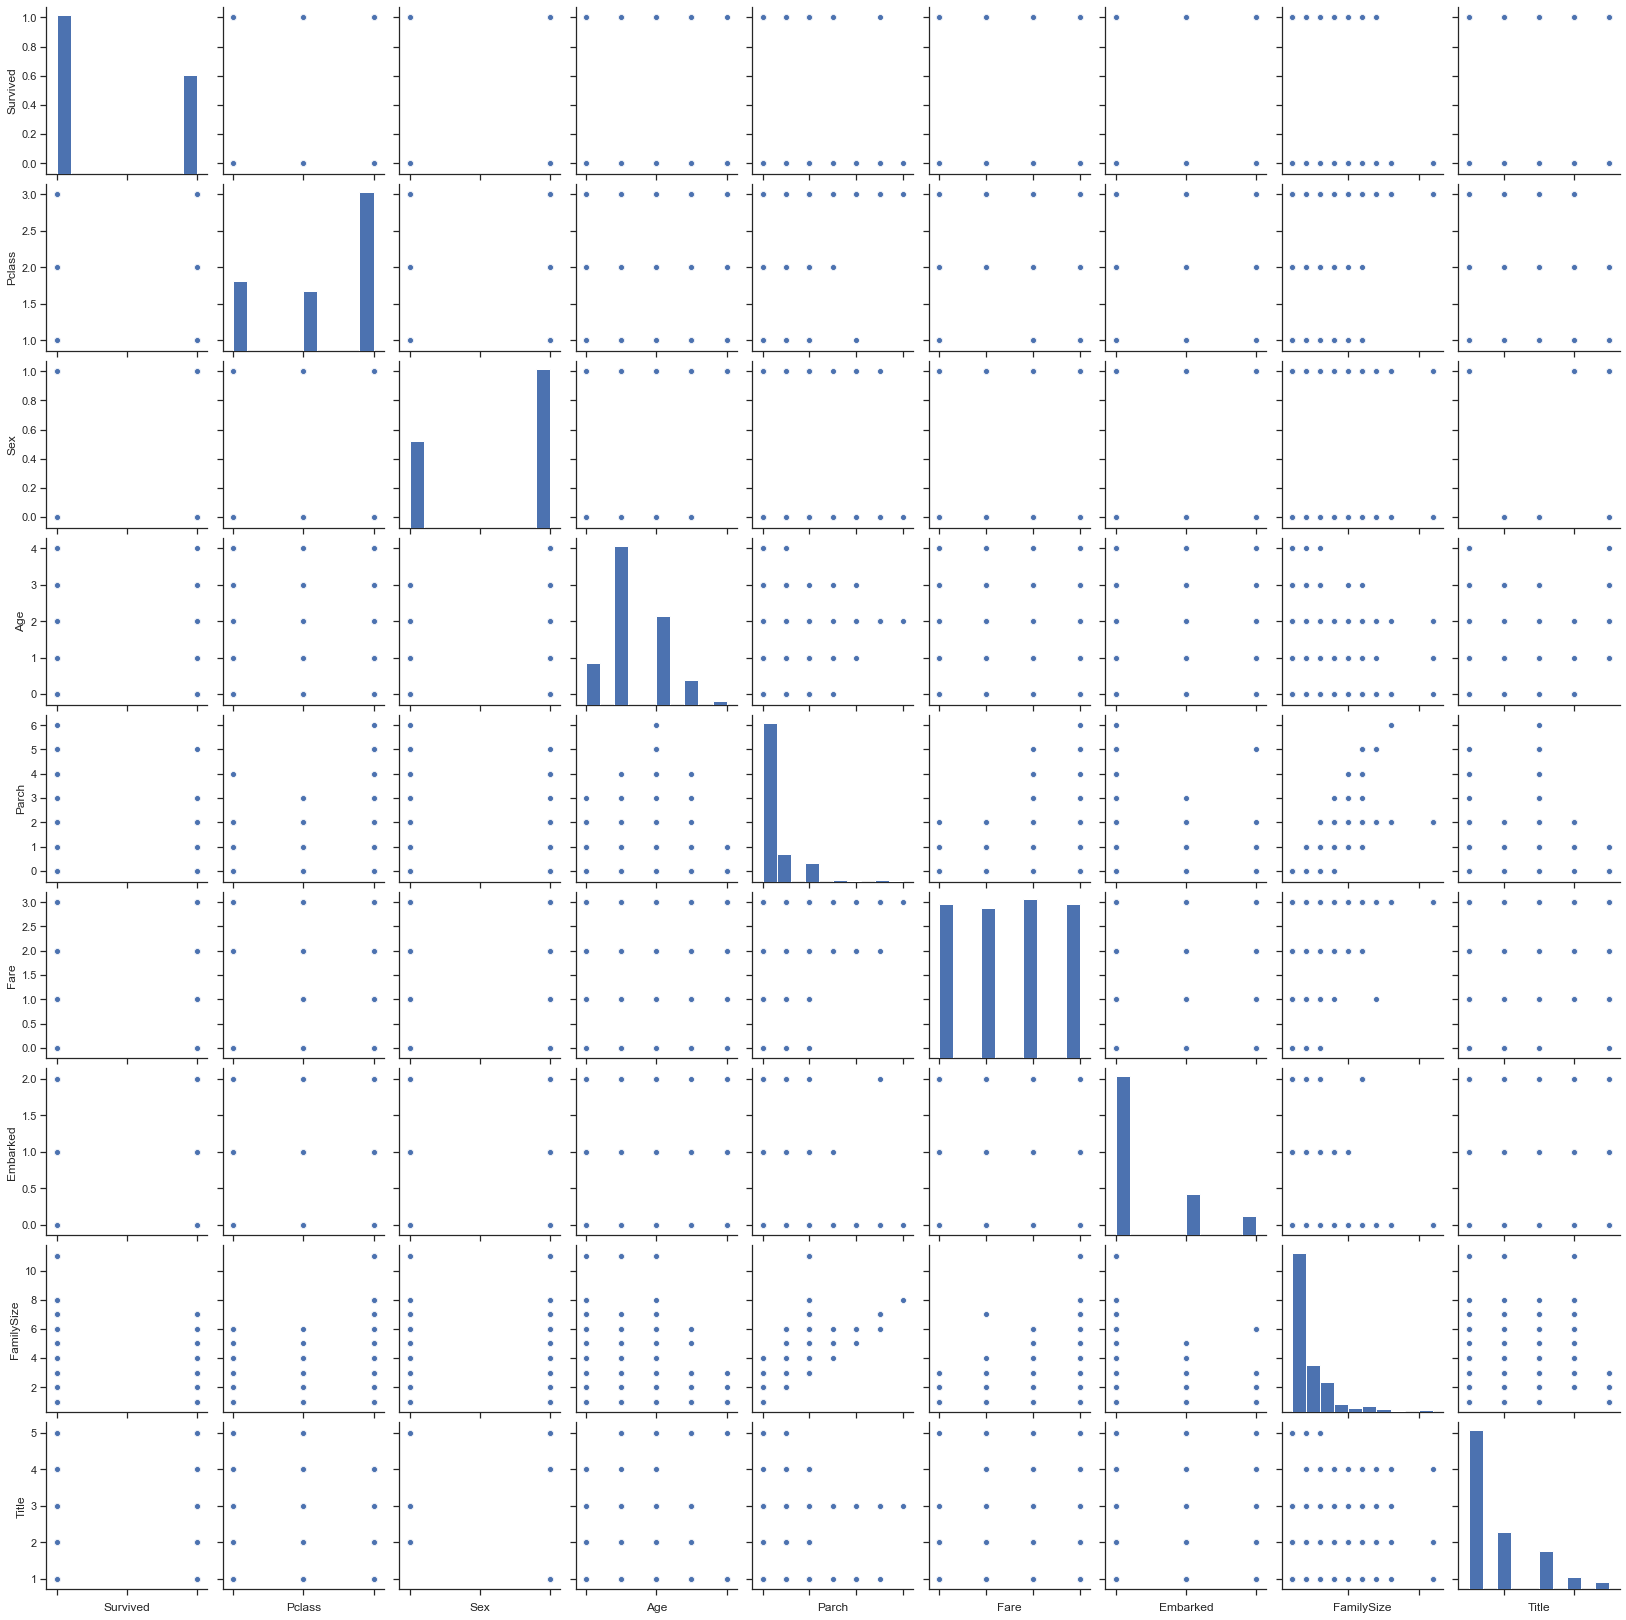

In [319]:
# lets look at the Pairplots to see the distribution of one variable with each other
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']])
g.set(xticklabels=[])

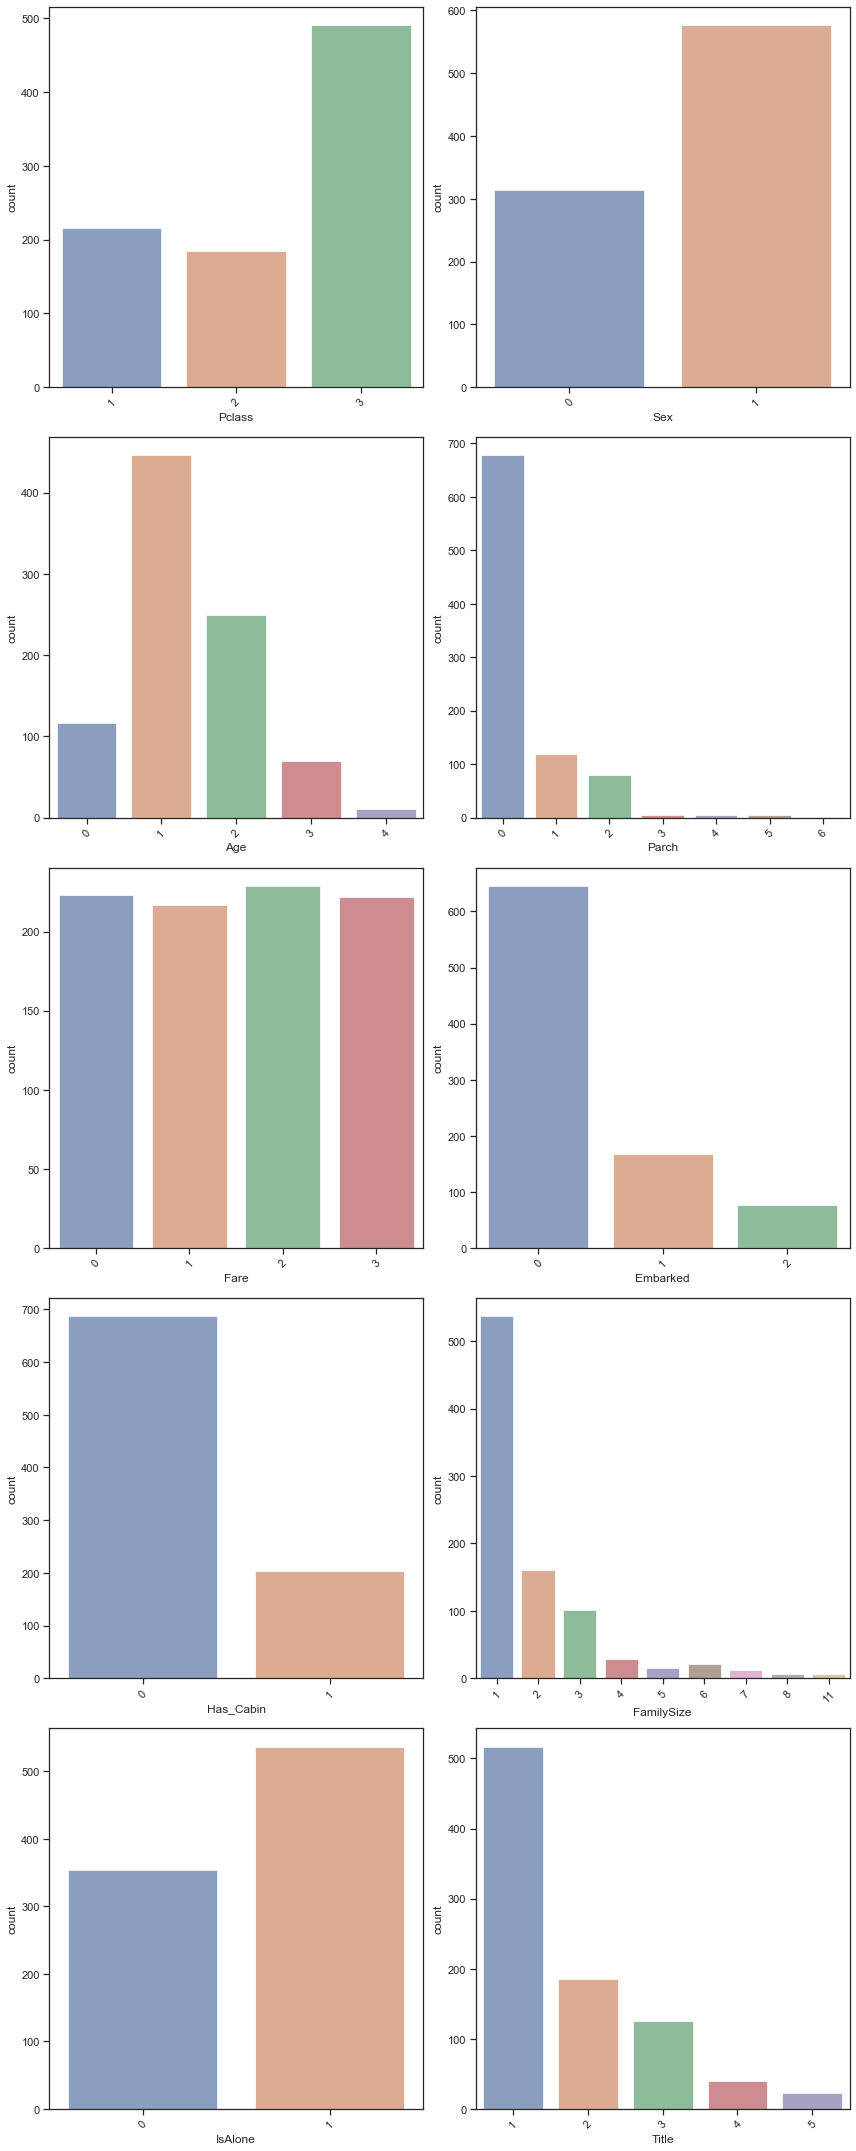

In [336]:
# Let's plot the number of values present in each column - training data

train_new = train[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']]

fig, axes = plt.subplots(round(len(train_new.columns) / 2), 2, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(train_new.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=train_new.columns[i], alpha=0.7, data=train_new, ax=ax)

fig.tight_layout()

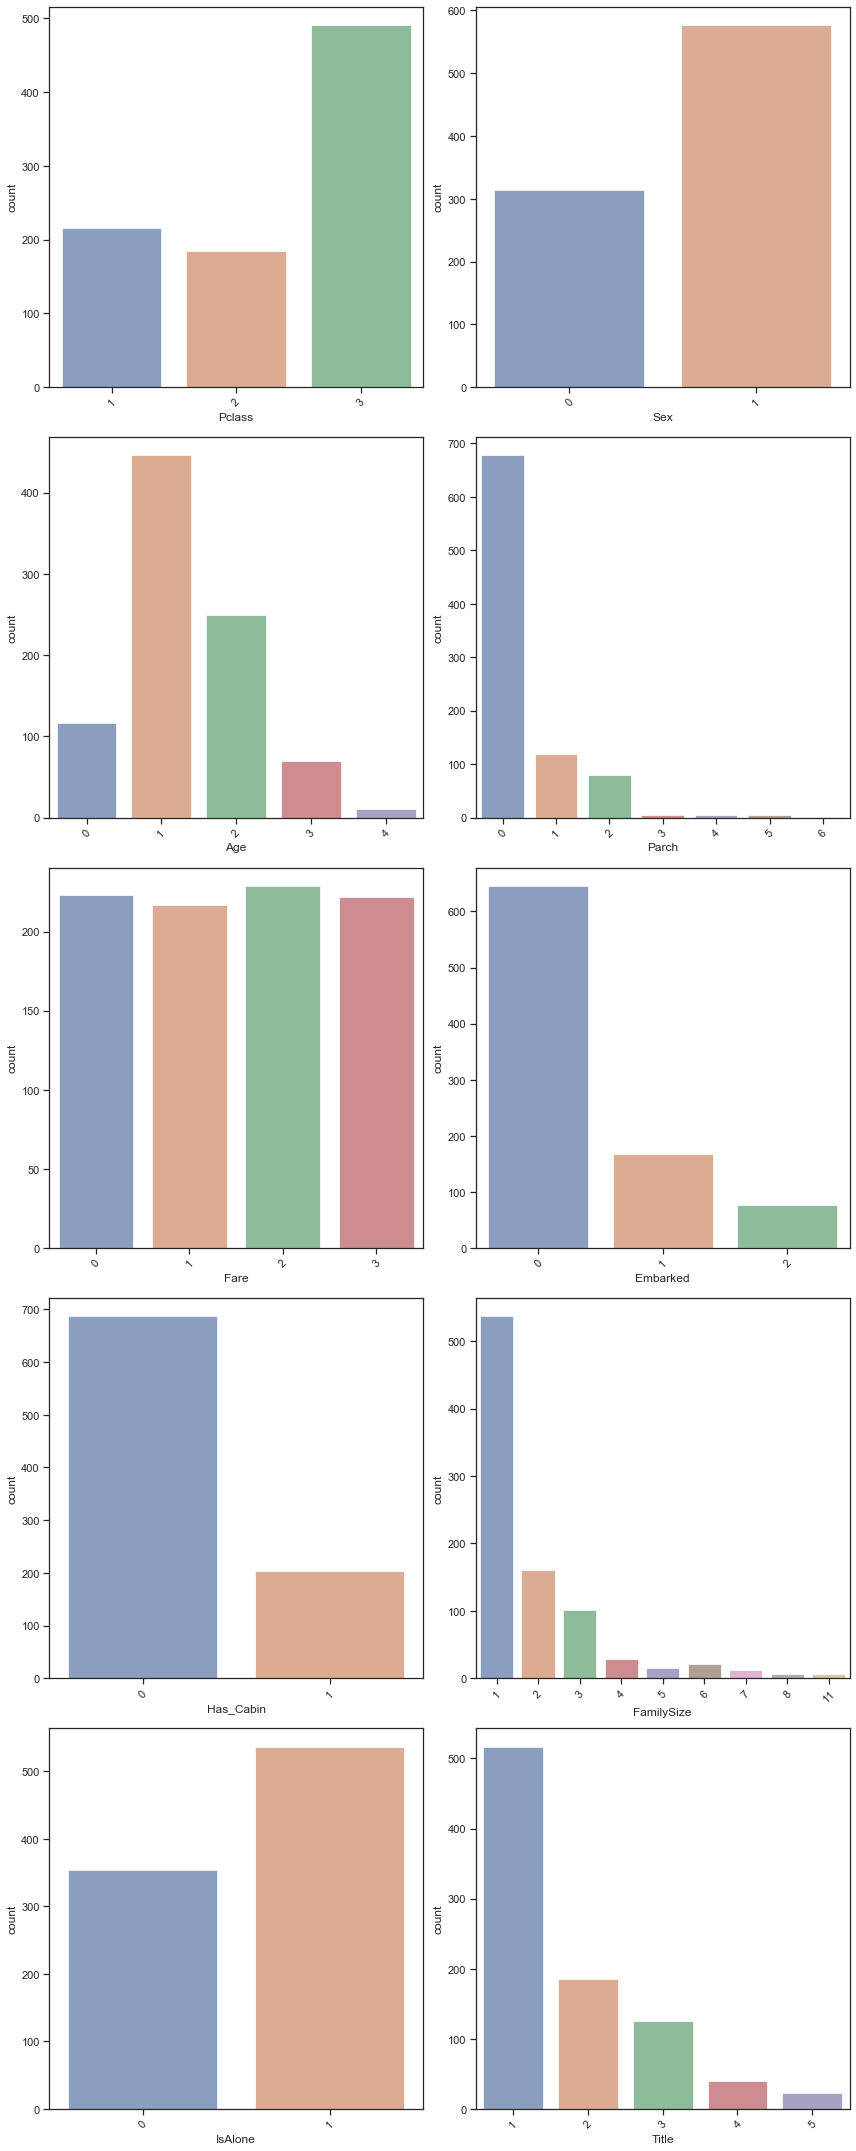

In [338]:
# Let's plot the number of values present in each column - test data

test_new = test[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']]

fig, axes = plt.subplots(round(len(train_new.columns) / 2), 2, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(train_new.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=train_new.columns[i], alpha=0.7, data=train_new, ax=ax)

fig.tight_layout()

### Modeling

#### Here we are building the XGBoost Classifier model

In [324]:
print(train.columns), print(test.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')
Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Survived',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'CategoricalFare',
       'CategoricalAge', 'Title'],
      dtype='object')


(None, None)

In [325]:
test = test.drop(['CategoricalFare', 'CategoricalAge'], axis = 1)

In [326]:
train.shape, test.shape

((891, 12), (418, 12))

In [327]:
print(train.columns), print(test.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')
Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Survived',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')


(None, None)

In [328]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
y_test = test['Survived'].ravel()

train = train.drop(['Survived'], axis=1)
test = test.drop(['Survived'], axis=1)

x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [330]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((891, 11), (891,), (418, 11), (418,))

In [331]:
train.dtypes

Pclass         int64
Sex            int64
Age            int64
Parch          int64
Fare           int64
Embarked       int64
Name_length    int64
Has_Cabin      int64
FamilySize     int64
IsAlone        int64
Title          int64
dtype: object

In [332]:
test.dtypes

Pclass           int64
Sex              int64
Age              int64
Parch            int64
Fare           float64
Embarked         int64
Name_length      int64
Has_Cabin        int64
FamilySize       int64
IsAlone          int64
Title            int64
dtype: object

In [353]:
# fit model on training data

from xgboost import XGBClassifier

model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
              subsample=0.8)

In [432]:
# grid search - parameter tuning

from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'n_estimators':(1,2000,400)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=500, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=20,iid=False, cv=5)

gsearch1.fit(x_train, y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([1.36226177e-02, 2.42167912e+00, 6.00138569e-01, 6.78095818e-03,
         3.64429779e+00, 7.82818651e-01, 5.88917732e-03, 3.63539920e+00,
         8.97426844e-01, 2.46744156e-03, 2.84587145e+00, 1.08884110e+00]),
  'std_fit_time': array([0.01386014, 0.00736502, 0.03134288, 0.00894148, 0.19494431,
         0.07684466, 0.00791999, 0.02774836, 0.00658268, 0.00075112,
         0.1569682 , 0.0083489 ]),
  'mean_score_time': array([0.00339723, 0.04299083, 0.01240344, 0.00236101, 0.06911945,
         0.02441525, 0.00867319, 0.03871698, 0.02235723, 0.0019403 ,
         0.02737055, 0.02290611]),
  'std_score_time': array([0.00178853, 0.00774034, 0.00899185, 0.00024487, 0.01527131,
         0.00118991, 0.00848025, 0.00577386, 0.00740525, 0.00018377,
         0.0027682 , 0.0038123 ]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, F

In [433]:
# fit model with best estimator

model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=400,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
              n_estimators=400, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
              subsample=0.8)

In [434]:
model.feature_importances_

array([0.07937999, 0.04227337, 0.09769845, 0.04274307, 0.10709253,
       0.07421324, 0.33818695, 0.03240958, 0.08783466, 0.01221231,
       0.08595585], dtype=float32)

In [435]:
# feature importance
feature_imp = []
for e, element in enumerate(train.columns):
    feature_imp.append((element, model.feature_importances_[e]))
    
feature_imp = sorted(feature_imp, key=lambda x:(-x[1],x[0]))

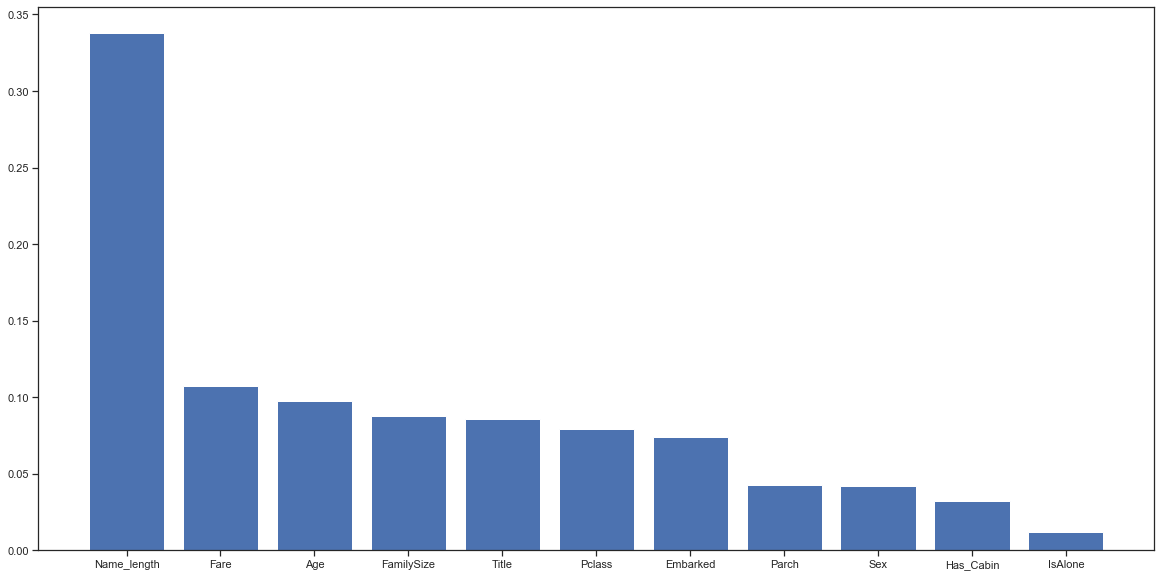

In [436]:
# plot the feature importances
plt.figure(figsize=(20,10))
plt.bar([i[0] for i in feature_imp], [i[1] for i in feature_imp])
plt.show()

#### Important features from the above plot are: 'Name_length', 'Fare', 'Age', 'FamilySize', and 'Title'

In [437]:
# training accuracy

y_pred2 = model.predict(x_train)
predictions2 = [round(value) for value in y_pred2]

accuracy2 = accuracy_score(y_train, predictions2)
print("Training Accuracy: %.2f%%" % (accuracy2 * 100.0))

Training Accuracy: 89.79%


In [438]:
# Make Predictions with XGBoost Model

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# make predictions for test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: %.2f%%" % (accuracy * 100.0))

Testing Accuracy: 84.69%


In [439]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [440]:
tn, fp, fn, tp

(227, 39, 25, 127)

In [441]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print("area under ROC curve: %.2f%%" % (metrics.auc(fpr, tpr) * 100.0))

area under ROC curve: 84.45%


In [442]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)

print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f_score: %.2f%%" % (f_score * 100.0))

Precision: 76.51%
Recall: 83.55%
f_score: 79.87%


#### Lets compare the XGBoost Classifier model performance with a more basic model like Random Forest

In [443]:
from sklearn import model_selection

# random forest model creation
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 10)
rfc.fit(x_train,y_train)

# predictions
rfc_predict = rfc.predict(x_test.astype(int))

In [429]:
param_test1 = {
 'max_depth':range(3,10,2),
 'n_estimators':range(1,2000,400)
}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 1000, max_depth = 10), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=20,iid=False, cv=5)

gsearch1.fit(x_train, y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([3.84378433e-03, 3.34103217e+00, 6.73514876e+00, 1.00884006e+01,
         1.32484323e+01, 7.22465515e-03, 3.50844936e+00, 6.74034572e+00,
         1.00982436e+01, 1.34728615e+01, 1.15346432e-02, 3.47555647e+00,
         6.92656226e+00, 1.04947128e+01, 1.40939579e+01, 1.08156204e-02,
         3.56962681e+00, 7.22530026e+00, 8.99820857e+00, 7.96573954e+00]),
  'std_fit_time': array([0.00032959, 0.02608375, 0.02866433, 0.04770574, 0.04965728,
         0.00713092, 0.02919352, 0.04767483, 0.02638672, 0.0459868 ,
         0.00892508, 0.02124348, 0.03241261, 0.0255466 , 0.08550792,
         0.00779993, 0.03475563, 0.01010315, 0.06510195, 0.03487152]),
  'mean_score_time': array([0.00234547, 0.21418896, 0.43928218, 0.63347702, 0.83486476,
         0.00453496, 0.22923889, 0.44537988, 0.64578538, 0.88427262,
         0.0110826 , 0.2154933 , 0.46672359, 0.6774869 , 0.86787591,
         0.00883412, 0.23389158, 0.41569386, 0.3279098 , 0.21552582]),
  'std_score_time': array

In [444]:
# random forest model creation
rfc = RandomForestClassifier(n_estimators = 1601, max_depth = 7)
rfc.fit(x_train,y_train)

# predictions
rfc_predict = rfc.predict(x_test.astype(int))

In [445]:
# Make Predictions with RF Model
# make predictions for test data
predictions = [round(value) for value in rfc_predict]

accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: %.2f%%" % (accuracy * 100.0))

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print("area under ROC curve: %.2f%%" % (metrics.auc(fpr, tpr) * 100.0))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)

print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f_score: %.2f%%" % (f_score * 100.0))

Testing Accuracy: 90.91%
area under ROC curve: 90.60%
Precision: 86.08%
Recall: 89.47%
f_score: 87.74%


#### By comparing both the models performance we can find the following differences:
1. For XGBoost model
Testing Accuracy: 84.69%;
area under ROC curve: 84.45%;
Precision: 76.51%;
Recall: 83.55%;
f_score: 79.87%;

2. For RF model
Testing Accuracy: 90.91%;
area under ROC curve: 90.60%;
Precision: 86.08%;
Recall: 89.47%;
f_score: 87.74%;

#### From the above numbers we can say that RF model has better performance over the XGBoost model in this case. This is the case where simple models can perform better than the complex models. The accuracy of 90% on test dataset is great with an f-score of 88%.